In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps.
import cartopy.feature as cft      
import numpy as np
import xarray as xr
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
from matplotlib import gridspec

import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc

from dask.distributed import Client

In [2]:
db='/g/data/x77/amh157/PanAnt/panant.db'
session=cc.database.create_session(db)
expts = ['panant-v2','panant-hycom1','panant-v3','panant-hycom1-v2']

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43597 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 103.08 GB


 # First half of function - reading in and processing data

In [8]:
outpath = './SWMT_temp' ## Set a path to dump data and make plots

expt = 'panant-hycom1-v2'

lat_north = -59
n = None
start_time , end_time = "1992-01" , "1992-12"
time_slice = slice(start_time,end_time)
lat_slice = slice(-90,lat_north)

In [5]:
# GET MOM6 VARIABLES
SST = cc.querying.getvar(expt,'tos',session,ncfile='ocean_daily.nc') 


# salt = cc.querying.getvar(expt,'salt',session,ncfile='ocean_daily.nc')
SSS_PSU =  cc.querying.getvar(expt,'sos',session,ncfile='ocean_daily.nc')
# net_surface_heating = cc.querying.getvar(expt,'net_heat_surface',session,ncfile='ocean_daily.nc')
net_surface_heating = cc.querying.getvar(expt,'hfds',session,ncfile='ocean_month.nc')
net_surface_heating = net_surface_heating.sel(time=time_slice, yh=lat_slice)
# pme_river = cc.querying.getvar(expt,'PRCmE',session,ncfile='ocean_daily.nc') # mass flux of precip - evap + river
pme_river = cc.querying.getvar(expt,'wfo',session,ncfile='ocean_month.nc') # mass flux of precip - evap + river

## slice for time and latitudinal constraints
SST = SST.sel(time=time_slice, yh=lat_slice)
SSS_PSU = SSS_PSU.sel(time=time_slice, yh=lat_slice)
pme_river = pme_river.sel(time=time_slice, yh=lat_slice)

## CONVERT TO MONTHLY
SST = SST.resample(time = "1M").mean("time")
SSS_PSU = SSS_PSU.resample(time = "1M").mean("time")
net_surface_heating = net_surface_heating.resample(time = "1M").mean("time")
pme_river = pme_river.resample(time = "1M").mean("time")


## extract coordinate arrays
yh = SST.yh.values
xh = SST.xh.values
time_monthly = SST.time.values
## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
start_month = int(start_time[5:7])
end_month = int(end_time[5:7])
n_years = int(len(SST.time)/12)
months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
if start_month != 1:
    months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
else:
    months_offset_noleap = months_standard_noleap

days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
depth = -0.541281 # st_ocean value of the uppermost cell

# Second half of function - unit conversions and Isopycnal Binning



In [6]:
depth_tile = xr.DataArray(
    data = np.full((len(yh),len(xh)),depth),
    dims = ["yh","xh"],
    coords = dict(
        yh=(["yh"],yh),
        xh=(["xh"],xh)
        
    )
)

## depth tile is just a constant array that coveres all xh and yh points! Make my own by just creating a new dataarray?

yh_global = np.tile(yh,(len(xh),1)).transpose()
xh_global = np.tile(xh,(len(yh),1))
pressure = xr.DataArray(p_from_z(depth_tile,yh_global), coords = [yh,xh], dims = ['yh','xh'], name = 'pressure', attrs = {'units':'dbar'})

# convert units to absolute salinity

SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,xh_global,yh_global), coords = [time_monthly, yh, xh], dims = ['time','yh', 'xh'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
## temperature saved, conversion will be required (make sure you work with C not K)
SST_Conservative = xr.DataArray(CT_from_pt(SSS,SST), coords = [time_monthly, yh, xh], dims = ['time','yh', 'xh'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
# compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
pot_rho_1 = xr.DataArray(sigma1(SSS, SST_Conservative), coords = [time_monthly, yh, xh], dims = ['time','yh', 'xh'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
pot_rho_1 = pot_rho_1.load()
# Compute salt transformation (no density binning)
haline_contraction = xr.DataArray(beta(SSS, SST_Conservative, pressure), coords = [time_monthly, yh, xh], dims = ['time','yh', 'xh'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction*SSS*pme_river*days_per_month #! before was PSU, why?
salt_transformation = salt_transformation.load()
# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST_Conservative, pressure), coords = [time_monthly, yh, xh], dims = ['time','yh', 'xh'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation =  thermal_expansion*net_surface_heating*days_per_month
heat_transformation = heat_transformation.load()
# Record the time bounds before summing through time (just to make sure it's consistent with requested years)
time_bounds =  str(salt_transformation.coords['time.year'][0].values)+'_'+str(salt_transformation.coords['time.month'][0].values)+'-'+str(salt_transformation.coords['time.year'][-1].values)+'_'+str(salt_transformation.coords['time.month'][-1].values)

#     Next section does a few things. It cycles through isopycnal bins, determines which cells are 
#     within the given bin for each month, finds the transformation values for those cells for each month, 
#     and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
#     where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
#     was within the bin, there it has a time summed transformation value.

isopycnal_bins = np.arange(31, 33.5, 0.02) ## alter if this density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used

bin_bottoms = isopycnal_bins[:-1]
binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yh), len(xh))), coords = [bin_bottoms, yh,xh], dims = ['isopycnal_bins', 'yh', 'xh'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})
for i in range(len(isopycnal_bins)-1):
    bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
    masked_transform = (salt_transformation * bin_mask).sum(dim = 'time') 
    masked_transform = masked_transform.where(masked_transform != 0) 
    masked_transform = masked_transform.load()
    binned_salt_transformation[i,:,:] = masked_transform
print('salt_transformation binning done')

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yh), len(xh))), coords = [bin_bottoms, yh,xh], dims = ['isopycnal_bins', 'yh', 'xh'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})


## This for loop is likely the least efficient part of the code. The problem can be vectorised for improved speed
for i in range(len(isopycnal_bins)-1):
    bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
    masked_transform = (heat_transformation * bin_mask).sum(dim = 'time') 
    masked_transform = masked_transform.where(masked_transform != 0)
    masked_transform = masked_transform.load()
    binned_heat_transformation[i,:,:] = masked_transform
print('heat_transformation binning done')

ndays = days_per_month.sum().values
salt_transformation = binned_salt_transformation/ndays
c_p = 3992.1
heat_transformation = binned_heat_transformation/c_p/ndays

isopycnal_bin_diff = np.diff(isopycnal_bins)
salt_transformation = salt_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
heat_transformation = heat_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# this procedure defines fluxes from lighter to denser classes as negative, I want the opposite
salt_transformation = salt_transformation *-1
heat_transformation = heat_transformation *-1


### DUMP OUTPUTS TO ARRAY

# Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
ds = xr.Dataset({'binned_salt_transformation': salt_transformation, 'time_bounds': time_bounds})
ds.to_netcdf(outpath+'/ST_'+time_bounds+'.nc')
ds = xr.Dataset({'binned_heat_transformation': heat_transformation, 'time_bounds': time_bounds})
ds.to_netcdf(outpath+'/HT_'+time_bounds+'.nc')
#############################################################
net_transformation = heat_transformation + salt_transformation
#############################################################
# wanted to rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'surface_water_mass_transformation': net_transformation, 'time_bounds': time_bounds})
ds.to_netcdf(outpath+'/SWMT_'+time_bounds+'.nc')


salt_transformation binning done
heat_transformation binning done


# Plotting section of notebook

Firstly SWMT over domain

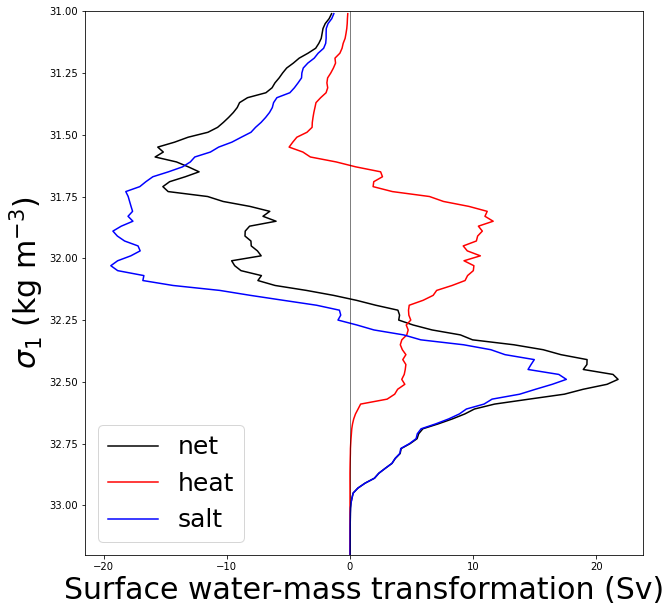

In [11]:
def get_SWMT(outpath, time_bounds):

    net_transformation = xr.open_dataset(outpath + '/SWMT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + '/HT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + '/ST_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation

area_t = cc.querying.getvar(expt, 'areacello', session, n=1) # this was changed from "area_t"
swmt, heat, salt = get_SWMT(outpath, time_bounds)
## sum over region, convert to Sv
isopycnal_bin_mid = swmt.isopycnal_bins
swmt_sum = (swmt * area_t/1e6).sum(['xh', 'yh']).values
heat_sum = (heat * area_t/1e6).sum(['xh', 'yh']).values
salt_sum = (salt * area_t/1e6).sum(['xh', 'yh']).values

figure = plt.figure(num=1, figsize = (10, 10))
plt.plot(swmt_sum,isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_sum,isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_sum,isopycnal_bin_mid, color = 'b', label='salt')
# plt.plot(salt_sum + heat_sum,isopycnal_bin_mid, color = 'g', label='sum')
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

## Create masks for ocean regions south of the 1000m Isobath
Used .where to find isobath and then a simple function to attempt to remove islands. Basically iterates backwards and forwards and checks whether a point is surrounded by sea


In [12]:
# Adele's script for isobath

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yh', yh), ('xh', xh)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yh', yh), ('xh', xh)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

# Write my own function that masks the 1000m isobath in Mom6
def remove_islands(array,width):
    width //= 2
    newarray = array
    for i in range(width,0,-1):
        newarray = newarray.where(newarray.roll(xh = i).values + newarray.roll(yh = i).values + 
                                newarray.roll(xh = -i).values + newarray.roll(yh = -i).values > 0,0)
    return newarray

depth = cc.querying.getvar(expt,'deptho', session, n=1) 
masked_depth = remove_islands(depth.where(depth < 1000,0).where(depth.yh < -58,0),40)
isobath_mask = masked_depth.where(masked_depth == 0,1)
# depth_mask.plot(size = 12)

# depth_mask_2 = remove_islands(depth_mask,40)

# Apply 1000m Isobath Mask

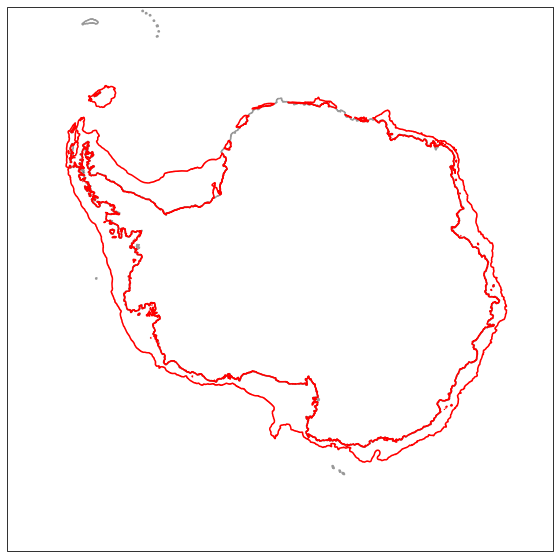

In [13]:
yh = depth.yh.values
xh = depth.xh.values
land_mask = (depth*0).fillna(1)
ht_shelf , shelf_mask = masked_depth, isobath_mask

fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xh, yh, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xh, yh, isobath_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

Shelf subduction density: 32.529999999999966


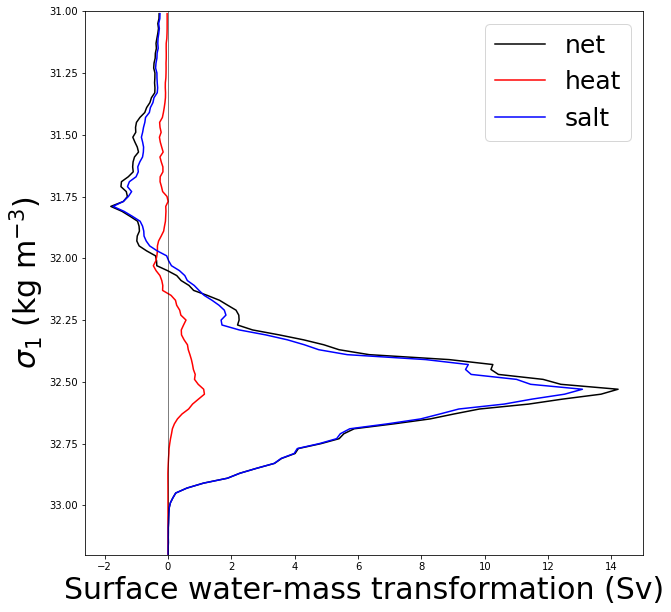

In [14]:

swmt_shelf = swmt * isobath_mask
heat_shelf = heat * isobath_mask
salt_shelf = salt * isobath_mask
area_t_shelf = area_t * isobath_mask
swmt_shelf_sum = (swmt_shelf * area_t_shelf/1e6).sum(['xh','yh']).values
heat_shelf_sum = (heat_shelf * area_t_shelf/1e6).sum(['xh','yh']).values
salt_shelf_sum = (salt_shelf * area_t_shelf/1e6).sum(['xh','yh']).values

max_transformation_index = np.argmax(swmt_shelf_sum) 
max_transformation_density = isopycnal_bin_mid[max_transformation_index]
print('Shelf subduction density:',max_transformation_density.values)

shelf_subduction_plot = swmt_shelf.isel(isopycnal_bins = max_transformation_index)*1e5
swmt_xt = shelf_subduction_plot.xh
swmt_yt = shelf_subduction_plot.yh

figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_shelf_sum, isopycnal_bin_mid, color = 'k',label='net')
plt.plot(heat_shelf_sum, isopycnal_bin_mid, color = 'r',label='heat')
plt.plot(salt_shelf_sum, isopycnal_bin_mid, color = 'b',label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);

# Plot SWMT mapped onto 1000m Isobath

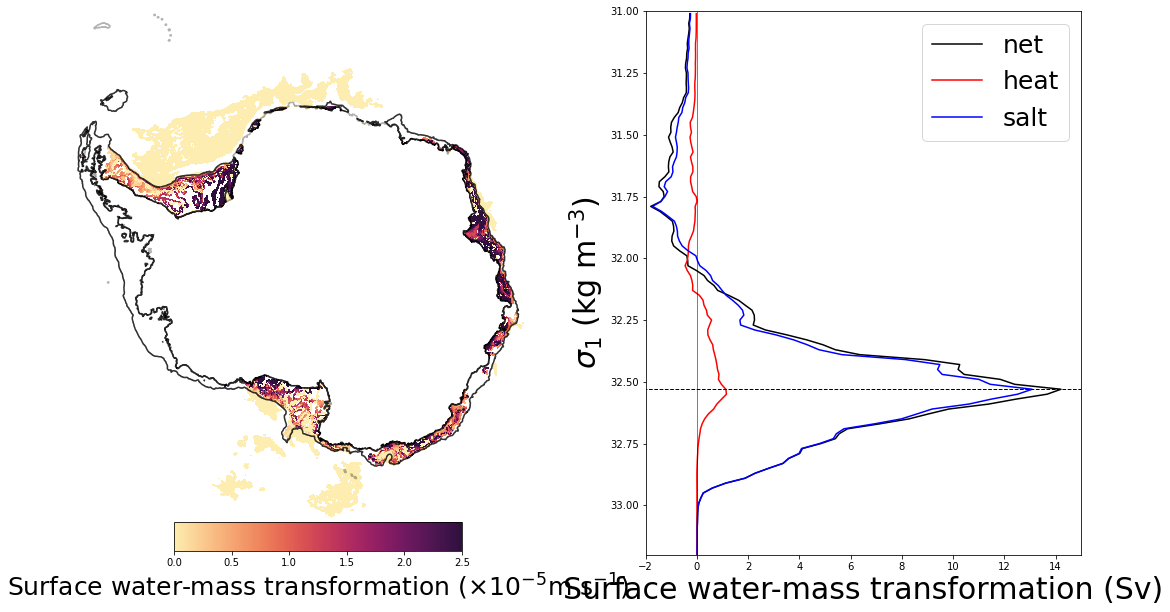

In [15]:
fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [3, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1])

ax.contour(xh, yh,land_mask, [0, 1],
           colors = 'k', alpha = 0.3, transform = ccrs.PlateCarree() )
ax.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask, [0, 1],
           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin=0, vmax=2.5, cmap=cmo.matter,transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
ax.outline_patch.set_visible(False)

cax = fig.add_axes([0.27, 0.13, 0.2, 0.04])
cbar=plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-5}$m s$^{-1}$)', fontsize = 25)

ax1.plot(swmt_shelf_sum,isopycnal_bin_mid, color = 'k',label='net')
ax1.plot(heat_shelf_sum,isopycnal_bin_mid, color = 'r',label='heat')
ax1.plot(salt_shelf_sum,isopycnal_bin_mid, color = 'b',label='salt')
ax1.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15],[max_transformation_density, max_transformation_density],'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-2, 15))
ax1.set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
ax1.set_xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
ax1.legend(loc=1, fontsize = 25);

## Compare shelf with total.

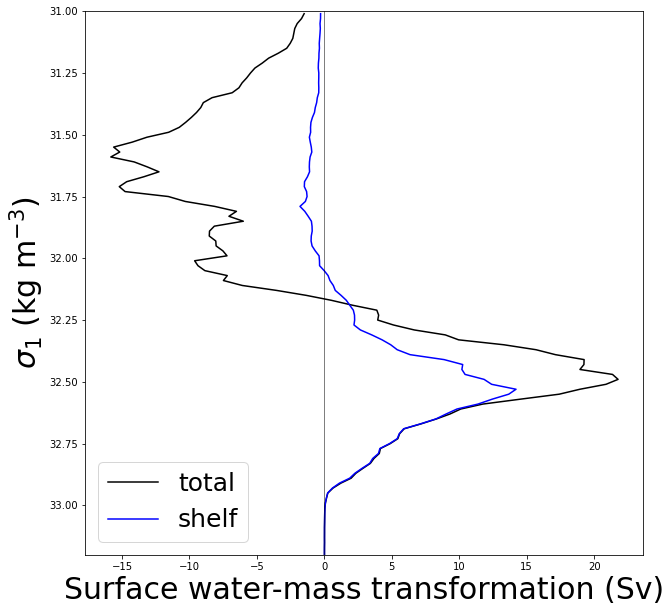

In [17]:
figure = plt.figure(num=1, figsize = (10, 10))
plt.plot(swmt_sum,isopycnal_bin_mid, color = 'k', label='total')
plt.plot(swmt_shelf_sum,isopycnal_bin_mid, color = 'b',label='shelf')
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);